In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/kaggle/code/core')
sys.path.append('/kaggle/input/my-flg-library/')
import flg_support as fls
import flg_unet
import flg_numerics
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [2]:
train_data = fls.load_all_train_data()
np.random.default_rng(seed=0).shuffle(train_data)

644

0
0.785739517211914 0.9844559669494629
1
0.7894588947296143 0.986181640625
2
0.834685230255127 0.9846076011657715
3
0.8084081649780274 0.9790000915527344
4
0.8502819061279296 0.979898738861084
5
0.8349843978881836 0.9768750190734863
6
0.8471831321716309 0.981045150756836
7
0.8493470191955567 0.9790397644042969
8
0.8382080078125 0.9819116592407227
9
0.8278957366943359 0.9778872489929199
10
0.8250110626220704 0.9740636825561524
11
0.8186510086059571 0.9764379501342774
12
0.8315926551818847 0.9758383750915527
13
0.8249711036682129 0.9774435997009278
14
0.8206162452697754 0.9767998695373535
15
0.8023981094360352 0.9755638122558594
16
0.7824828147888183 0.9718008041381836
17
0.7703310012817383 0.975832176208496
18
0.7861270427703857 0.9772006034851074
19
0.7642507076263427 0.9740679740905762
20
0.7676513195037842 0.9747682571411133
21
0.7579151153564453 0.970093059539795
22
0.7690893173217773 0.9752821922302246
23
0.7702218532562256 0.9713508605957031
24
0.7765801429748536 0.975420856475830

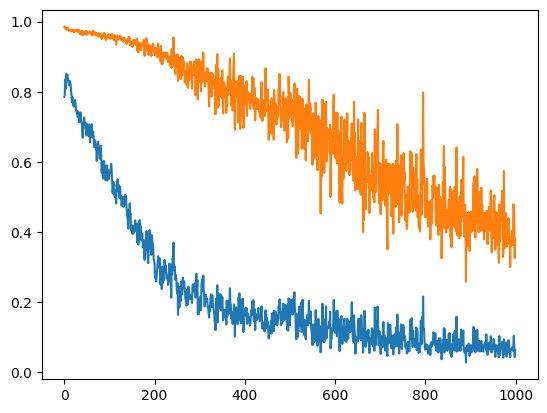

In [3]:
%%time
importlib.reload(flg_unet)
#importlib.reload(fls)
model = flg_unet.UNetModel()
model.n_epochs = 1000
model.n_images_per_update = 20
model.deterministic_train = False
model.train(train_data[:550])
model.train_loss_list1
plt.figure()
plt.plot(model.train_loss_list1)
plt.plot(model.train_loss_list2)
fls.dill_save(fls.temp_dir + 'model_cv.pickle', model)

In [4]:
model_loaded = fls.dill_load(fls.temp_dir + '/model_cv.pickle')
training_data_loaded = copy.deepcopy(train_data[551:])
for t in training_data_loaded: t.load_to_h5py()
cpu,device = fls.prep_pytorch(0,False,False)
#model_loaded.model.eval()
#model_loaded.model.to(device);

In [ ]:
import monai
self = model_loaded
cpu,device = fls.prep_pytorch(self.seed, self.deterministic_train, True)  

criterion1 = nn.BCEWithLogitsLoss()
criterion2 = monai.losses.TverskyLoss(smooth_nr=1e-05, smooth_dr=1e-05, batch=True, to_onehot_y=False, sigmoid=True, \
                                         alpha=self.tversky_alpha, beta=self.tversky_beta)

model = copy.deepcopy(self.model)
model.eval()
model = model.to(device)

self.dataset.data_list = copy.deepcopy(train_data[551:])
self.n_images_per_update = 10
data_loader = iter(torch.utils.data.DataLoader(self.dataset,batch_size=self.n_images_per_update,num_workers=0,pin_memory=True,persistent_workers=False))

for i_epoch in range(5):
    print(i_epoch)
    running_loss1 = 0.0
    running_loss2 = 0.0
    images, targets = next(data_loader)
    N=1
    for i_image in range(images.shape[0]//N):
        with torch.amp.autocast('cuda'):
            
            with torch.no_grad():
                image_device = images[N*i_image:N*i_image+N,np.newaxis,:,:,:].to(device, dtype=torch.float16, non_blocking=True)
                target_device = targets[N*i_image:N*i_image+N,np.newaxis,:,:,:].to(device, dtype=torch.float16, non_blocking=True)
                output = model(image_device)                                    
                loss1 = criterion1(output, target_device)
                loss2 = criterion2(output, target_device)                                                
                running_loss1 += loss1
                running_loss2 += loss2
        #print(loss2.item())
        _,ax = plt.subplots(1,3,figsize=(18,6))
        plt.sca(ax[0])
        plt.imshow(np.mean(image_device.detach().cpu().numpy()[0,0,:,:,:],axis=0), cmap='bone')
        plt.colorbar()
        plt.sca(ax[1])
        plt.imshow(np.mean(target_device.detach().cpu().numpy()[0,0,:,:,:],axis=0), cmap='bone')
        plt.colorbar()
        plt.sca(ax[2])
        plt.imshow(np.mean(torch.sigmoid(output).detach().cpu().numpy()[0,0,:,:,:],axis=0), cmap='bone')
        plt.colorbar()
        plt.suptitle(str(loss1.item())+' '+str(loss2.item()))

    epoch_loss1 = running_loss1 / images.shape[0]
    epoch_loss2 = running_loss2 / images.shape[0]
    loss = epoch_loss1 + epoch_loss2

0
